# Value at Risk (VaR)

VaR is a statistical risk measure primarily used in finance that may be computed in different ways. VaR is defined for a given a time period (ex: 1 day) and confidence level *p*, and tells you the maximum value/amount (ex: dollar) that an investment portfolio may lose. So if a certain portfolio has a one day, 95% VaR of $1M, it means that the portfolio may not lose more than \$ 1M in value, in a one day time period, at the 95% confidence level. Note the following implications: 
* there is a probability of (1-p) that the portfolio will lose more than the VaR value
  * in the example above, there is a 5% probability that said portfolio will lose more than $1M in the one day time period
  * in these extreme cases the CVaR (`Conditional VaR` also known as `expected shortfall`) measure is used; it takes into account breaching this VaR value and it is a weighted average of the "extreme" losses in the tail of the distribution of possible returns
* VaR scales with the square root of time. So in the above example, the 5 day VaR (at 95% ci, for the same portfolio) is $\$1,000,000 * \sqrt{5} = \$2,236,068$

You may calculate VaR non-parametrically or parametrically however these two categories are further brokend down into:
* Historical VaR - this is a non-parametric method that takes historial returns for the asset/portfolio, for a certain period of time and given a certain confidence level will return the expected loss.
  * obviously the past is not a predictor for the future so this measure is merely using past data. Not a great way to do it but it is something...
* Variance-Covariance VaR - is a parametric method that assumes certain asset volatilities $\sigma_{i}$ and asset pair correlations $\rho_{i,j}$. Then assuming a distribution of returns, say a normal distribution, calculates the portfolio VaR using the corresponding confidence level
  * so for a 95% confidence interval (single sided) the one day VaR = Value of portfolio x 1.96 x variance of portfolio
* Monte Carlo Method - is another parametric method that basically allows you to tweak more variables than the Variance-Covariance method and simulates every tweakable aspect of the calculation. Ultimately the VaR value is derived from a more fine grained simulation. 

## Historical VaR

Below we will calculate Historical VaR for Amazon from 2019-07-11 through 2022-07-13.

         date    adjclose    return
0  2019-07-11  100.053497       NaN
1  2019-07-12  100.550003  0.004962
2  2019-07-15  101.049500  0.004968
3  2019-07-16  100.495003 -0.005487
4  2019-07-17   99.601501 -0.008891


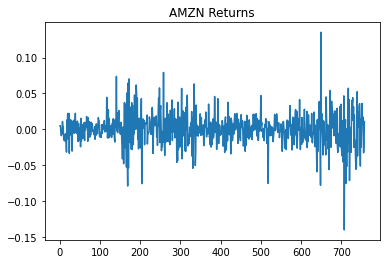

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
amzn = pd.read_csv("amzn_var.csv")
data_return = amzn["return"]
print(amzn.head(5))
plt.title("AMZN Returns")
plt.plot(data_return)

There are 757 returns in data_return


Text(0.5, 1.0, 'AMZN returns Histogram')

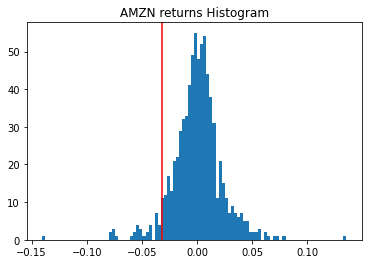

In [2]:
percentile = 0.999
hist_var_90 = data_return.quantile(0.1)
hist_var_95 = data_return.quantile(0.05)
hist_var_99 = data_return.quantile(0.01)
hist_var_custom = data_return.quantile(1 - percentile)
hist_var_list = [hist_var_90, hist_var_95, hist_var_99, hist_var_custom]
print("There are {0} returns in data_return".format(data_return.count()))
plt.axvline(x=hist_var_95, color="red")
plt.hist(data_return, bins=100)
plt.title("AMZN returns Histogram")

We can easily calculate the 95% one day VaR on a $1M portfolio by calculating: 

$VaR_{1d, 95\%} = \$1,000,000 * histvar95$

$VaR_{1d, 95\%} = \$1,000,000 * -.032172$

$VaR_{1d, 95\%} = -\$32,172.9$

Below are the corresponding values as well as a quick check that hist_var_95 does in fact match with the record that is right at the 5% cuttoff/position of the sorted values. 

In [3]:
from math import ceil
sorted_data_return = data_return.sort_values(axis=0)
print("Value of hist_var_95 is {0}".format(hist_var_95))
print("Therefore, the one day 95% VaR of a portfolio of $1M worth of AMZ is ${0:,.2f}".format(1e6 * hist_var_95))
print("Just as a quick check there are {0} intances of values less than the hist_var_95 return".format(sorted_data_return[sorted_data_return < hist_var_95].count()))
print("With {0} records in the data_return Series, we expect %5 of the values to be {1} records in total".format(data_return.count(), ceil(data_return.count()*.05)))

Value of hist_var_95 is -0.03217290748669776
Therefore, the one day 95% VaR of a portfolio of $1M worth of AMZ is $-32,172.91
Just as a quick check there are 38 intances of values less than the hist_var_95 return
With 757 records in the data_return Series, we expect %5 of the values to be 38 records in total


## Variance-Covariance VaR

In [4]:
from scipy.stats import norm

def value_at_risk(pos, p, mu, sigma):
    alpha = norm.ppf(1-p)
    var = pos*(mu-sigma*alpha)
    return var

portfolio_value = 1e6
p = 0.95
mu = np.mean(data_return)
sigma = np.std(data_return)
variance_covariance_var = value_at_risk(portfolio_value, p, mu, sigma)

print("Using the Variance-Covariance method, the one day 95% VaR of a portfolio worth ${0:,.2f} of AMZ is -${1:,.2f}".format(portfolio_value, variance_covariance_var))


Using the Variance-Covariance method, the one day 95% VaR of a portfolio worth $1,000,000.00 of AMZ is -$36,687.54


## Monte Carlo Simulation

In [5]:
class ValueAtRiskMoneteCarlo:
    def __init__(self, S, mu, sigma, p, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.p = p
        self.n = n
        self.iterations = iterations
        
    def simulation(self):
        stock_data = np.zeros([self.iterations,1])
        rand = np.random.normal(0,1,[1,self.iterations])
        
        # equation for S(t) stock price
        stock_price = self.S*np.exp(self.n*(self.mu-0.5*self.sigma**2)+ self.sigma*np.sqrt(self.n)*rand)
        
        #we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)
        
        #it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price,(1-self.p*-100))
        #percentile = np.percentile(stock_price,5)
        
        return self.S-percentile

iterations = 100000
n = 1

mc_model = ValueAtRiskMoneteCarlo(portfolio_value, mu, sigma,p,n,iterations)
mc_var = mc_model.simulation()
print("Using Monte Carlo Simulation, the one day 95% VaR of a portfolio worth ${0:,.2f} of AMZ is -${1:,.2f}".format(portfolio_value, mc_var))


Using Monte Carlo Simulation, the one day 95% VaR of a portfolio worth $1,000,000.00 of AMZ is -$-39,689.87
